# 6º Período - Pré-processamento, Representação Vetorial e Classificação de Textos

## Introdução

O foco desse relatório será nas Redes Neurais Recorrentes (RNN), frequentemente utilizadas para tradução e previsão de textos, e que funcionam de forma deveras diferente das Redes Neurais explicadas anteriormente. Serão introduzidos alguns novos termos:



*   Tokenização
*   Bag-of-words (BOW)
*   Term-frequency inverse document-frequency (TFIDF)
*   Word embeddings
*   Redes Neurais Recorrentes (RNNs)
*   Gated Recurrent Unit (GRU)
*   Long-short-term memory (LSTM)





### Tokenização

Para a construção de modelos que fazem a tradução e previsão de textos, é necessário um ótimo pré-processamento dos dados, porque sabemos o quão confuso e diversa a escrita pode ser, além de que o computador não tem a capacidade de reconhecer letras ou palavras diretamente, mas sim vetores de números (tokens) que representam letras. É possível adicionar no modelo camadas de pré-processamento dos dados, o que pode ser de valiosa ajuda.

### Bag-of-Words

A Bag of Words, ou mochila/bolsa de palavras, é a contagem da frequência de cada palavra em um texto.

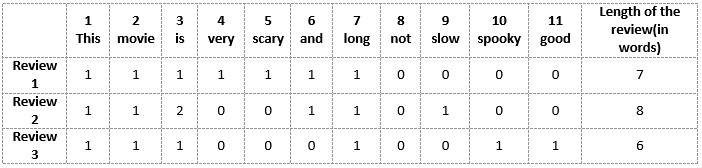

### TFIDF

técnica de normalização para que as palavras que aparecem mais não pesem muito, feita da forma: $$x / log\sum_{}^{}x$$

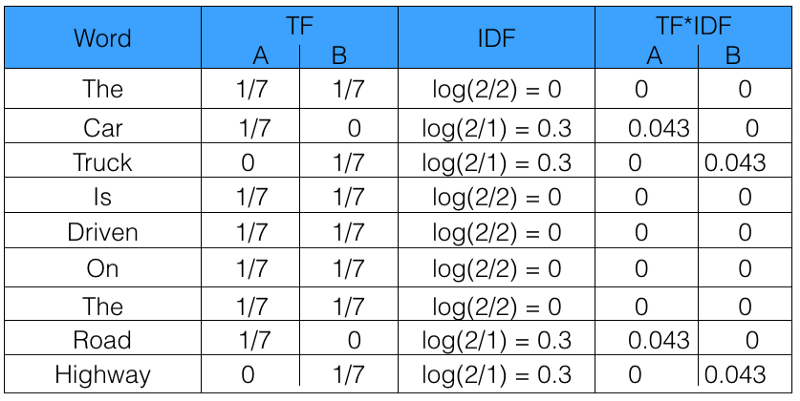

### Word Embeddings

É uma alternativa de categorização junto ao one-hot encoding, se existirem mais de 50 categorias, utilizar o embedding. Representa as categorias (ou palavras) em vetores e possui capacidade de aprendizado, por exemplo as palavras Rei, Homem, Mulher e Rainha, cada uma com o seu vetor. Se você realizar a operação: **Rei - Homem + Mulher**, o vetor embedding será próximo ao embedding da palavra Rainha. Mostrando que possui capacidade de aprendizado de gênero.

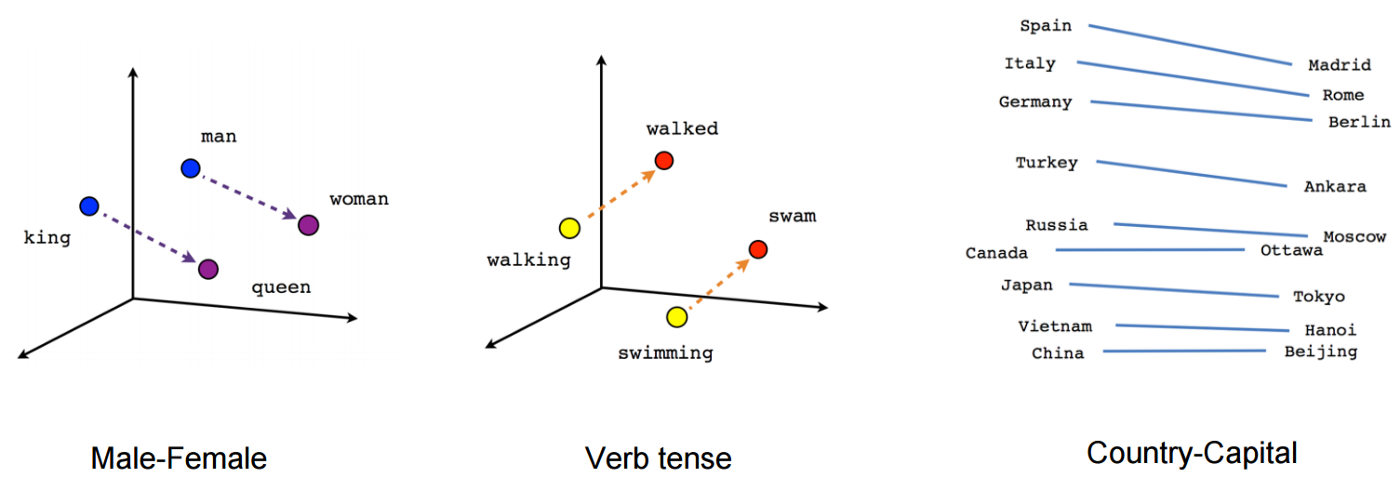

### Redes Neurais Recorrentes

A diferença de uma RNN para uma NN normal, é que na RNN o *output* é realimentado ao próprio neurônio. Possuindo um peso para o *output* "antigo" e outro peso diferente para o *input* que está por vir, o que possibilita certa capacidade de **memória** ao neurônio.

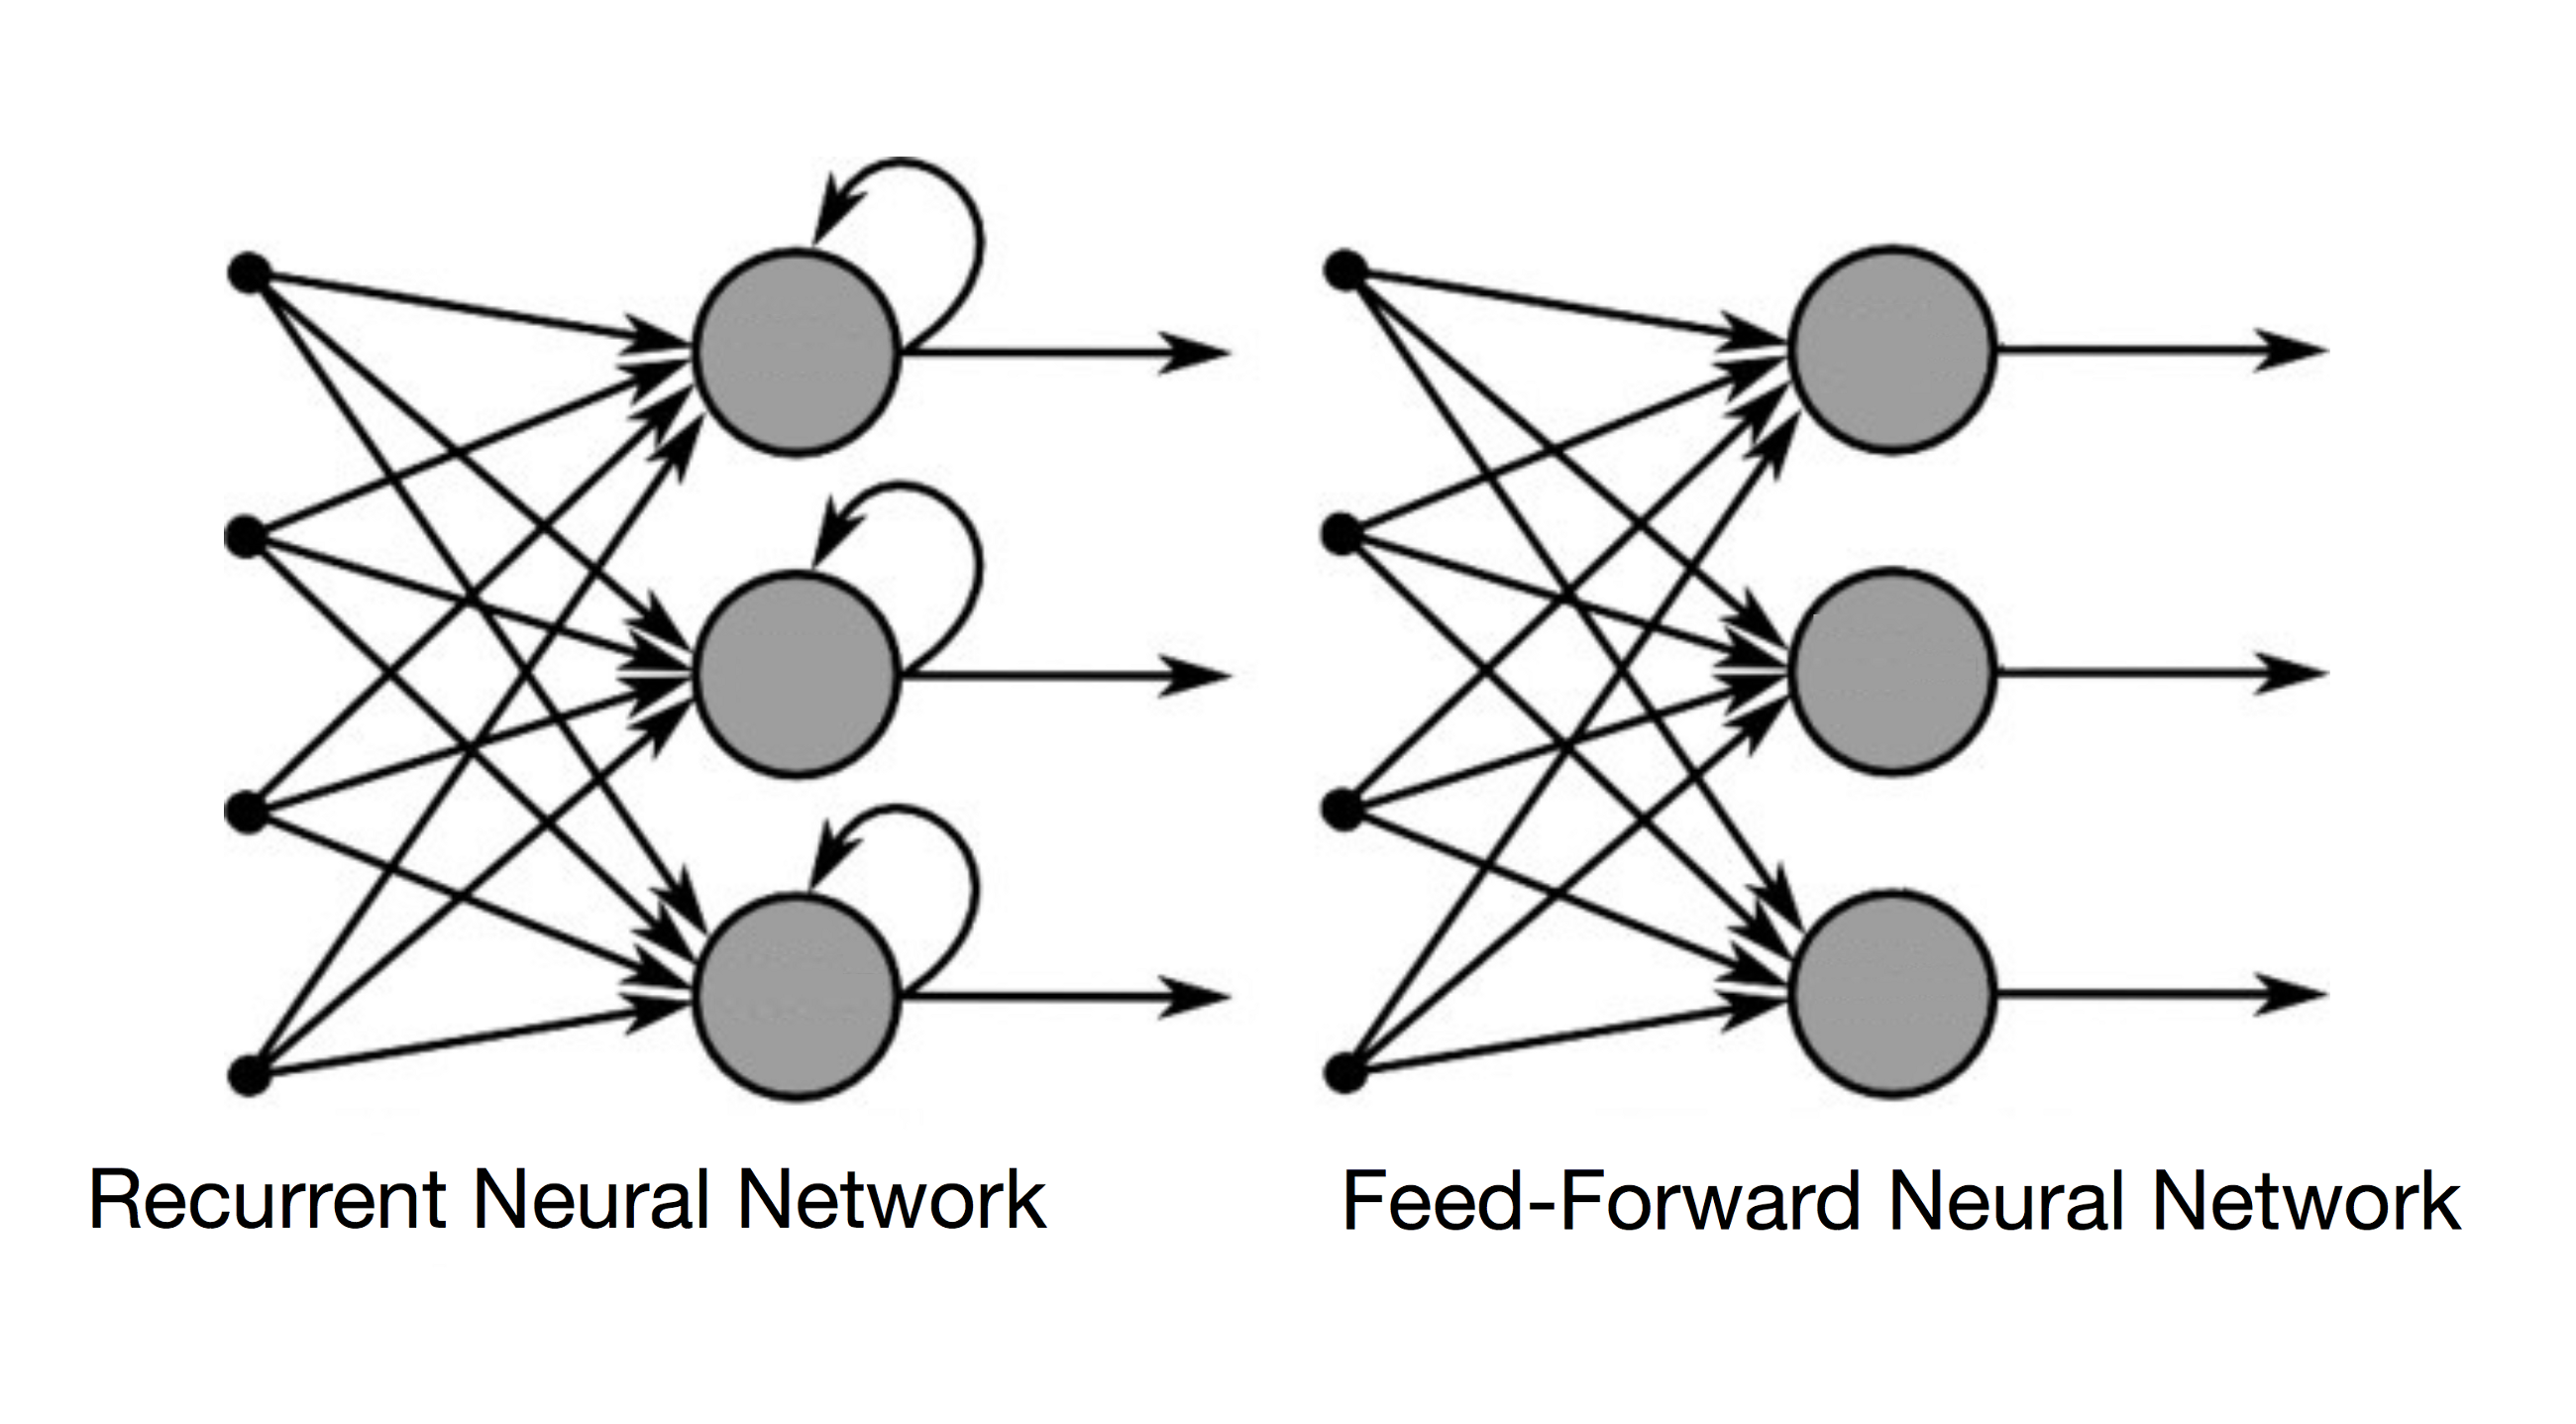

### Long-short-term memory

RNN na estrutura Long Short-Term Memory (LSTM) são redes capazes de aprender a dependência de ordem em uma sequência de predições de problemas. Esse comportamento requerido em problemas complexos estão presentes em tradução, reconhecimento de fala e mais. 

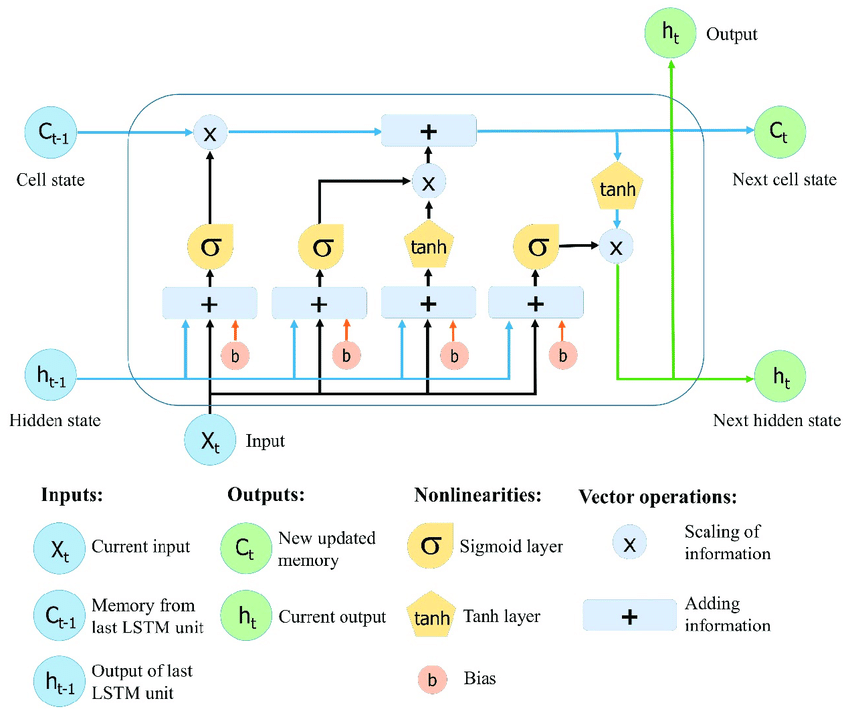



### Gated Recurrent Unit (GRU)

Gated Recurrent Unit são uma versão improvisada das Redes Neurais Recorrentes. Construídas para resolver o problema do gradiente que some de uma RNN padrão, os GRUs usam chamados update gate and reset gate. Basicamente, existem dois vetores que decidem qual informação deve ser passada ao output e qual não deve. O que há de especial nisso é que esses vetores conseguem ser treinados para conter informação que já foi passada (ou não) por muito tempo, sem "esquecê-la" de acordo com as épocas e também podem ser treinadas para remover informações que são irrelevantes para a predição.

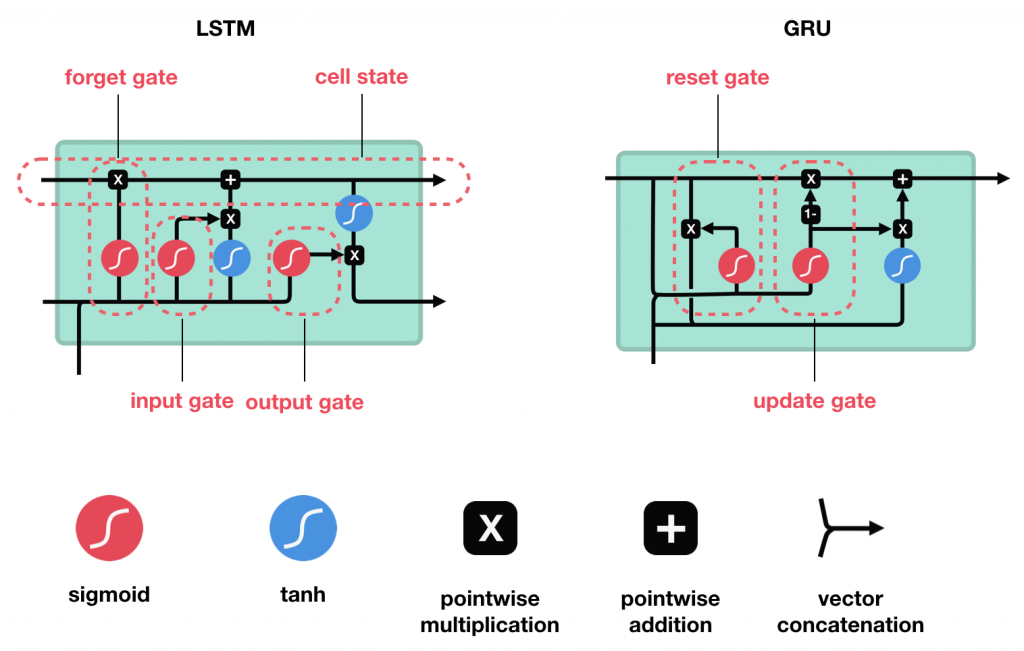

### Pacotes necessários:

In [ ]:
!pip install sklearn2pmml

In [11]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from pathlib import Path  
import glob
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn.pipeline import Pipeline 
from sklearn.svm import SVC
from sklearn.utils import resample
#import contractions

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

## Dados

In [4]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

dataset_path = '/content/gdrive/MyDrive/Musical_instruments_reviews.csv'

Mounted at /content/gdrive


In [22]:
df = pd.read_csv(dataset_path)

df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [23]:
df.shape

(10261, 9)

In [24]:
df.isna().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

Como o número de NAs é insignificante, não há problema em ignorar essas linhas

In [25]:
df = df.dropna()
df.isna().sum()

reviewerID        0
asin              0
reviewerName      0
helpful           0
reviewText        0
overall           0
summary           0
unixReviewTime    0
reviewTime        0
dtype: int64

In [26]:
df.shape

(10227, 9)

## Agora, vamos Balancear o Dataset:

In [27]:
df.overall.value_counts()

5.0    6912
4.0    2079
3.0     771
2.0     249
1.0     216
Name: overall, dtype: int64

Como existem pouquíssimas classificações de número 1, 2 e 3 comparados às classificações de nota 4 e 5, vamos balancear os dados (Downsample, para evitar o overfitting) para que não comprometam o resultado do nosso modelo, como já fizemos em períodos e análises passadas:

In [28]:
df_5 = df[df['overall']==5.0]
df_4 = df[df['overall']==4.0]
df_3 = df[df['overall']==3.0]
df_2 = df[df['overall']==2.0]
df_1 = df[df['overall']==1.0]

df_5 = resample(df_5, replace=False, n_samples=249)
df_4 = resample(df_4, replace=False, n_samples=249)
df_3 = resample(df_3, replace=False, n_samples=249)

df = pd.concat([df_5,df_4, df_3, df_2, df_1])

df.overall.value_counts()

5.0    249
4.0    249
3.0    249
2.0    249
1.0    216
Name: overall, dtype: int64

Podemos também fazer uma classificação binária.  será uma avaliação positiva e 0 uma avaliação negativa:

In [29]:
df['binary'] = df['overall']

In [ ]:
df['binary'][df['overall']==5.0] = 1
df['binary'][df['overall']==4.0] = 1
df['binary'][df['overall']==3.0] = 0
df['binary'][df['overall']==2.0] = 0
df['binary'][df['overall']==1.0] = 0

In [31]:
df1.binary.value_counts()

0.0    714
1.0    498
Name: binary, dtype: int64

## Função de pré-processamento dos dados usando RegEx e NLTK;

(lowercasing, remover pontuações, stopwords, lemmatize, etc);

In [21]:
def pre_processing_regex(texto, patterns):
  novo = texto.tolist()
  for frase in novo:
    novo_texto = re.sub(patterns, lambda m: m.group(0).lower(), frase)
    novo_texto = novo_texto.translate(str.maketrans('', '', string.punctuation))
    novo.append(novo_texto)
  return novo

#phrase = ['TESTANDO, 1. 2. 3. 123!!','Que vontade DE UM STROGONOFF CARA!!! SERIO BRO??? ;-;']

phrase = df['reviewerName'].head(1)
padrao= '[A-Z]+'

# pre_processing_regex(phrase,padrao)

Apesar de criar a função e ela estar funcional, não a utilziaremos por existirem diversos métodos mais eficientes e intuitivos para pré processar os dados, como utilizando o NLTK:

In [32]:
data = df[['reviewText','summary']]

A **primeira ação** ao texto é expandir as contrações das palavras, ou seja, "I´ve" se torna "I have" e são tokenizados juntos, ou seja, não são alocadas diferentes como em "I" "have". A **segunda ação** é a Tokenização, ou seja, cada palavra individual vai ser dividida em um token. A **terceira ação** é converter todas as palavras para a letra minúscula. A **quarta ação** é para remover as pontuações. A **quinta ação** é para remover as chamadas "stop words", também chamadas de palavras vazias, ou seja, palavras sem significado (já definidas em uma função). A **sexta e última ação** é a chamada de "Lemmatization", que classifica as palavras em adjetivo, verbo, pronome, substantivo e etc.

In [33]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def pre_processing_nltk(data):
  for column in data.columns:
 #   data[column] = data[column].apply(lambda x: [contractions.fix(word) for word in x.split()])

    data[column] = data[column].apply(word_tokenize)

    data[column] = data[column].apply(lambda x: [word.lower() for word in x])
 
    data[column] = data[column].apply(lambda x: [word for word in x if word not in string.punctuation])

    data[column] = data[column].apply(lambda x: [word for word in x if word not in stop_words])

    data[column] = data[column].apply(nltk.tag.pos_tag)

    data[column] = data[column].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

    wnl = WordNetLemmatizer()
    data[column] = data[column].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

  return data

def preprocessnltk(data):
  data['reviewText'] = data['reviewText'].apply(word_tokenize)

  data['reviewText'] = data['reviewText'].apply(lambda x: [word.lower() for word in x])
 
  data['reviewText'] = data['reviewText'].apply(lambda x: [word for word in x if word not in string.punctuation])

  data['reviewText'] = data['reviewText'].apply(lambda x: [word for word in x if word not in stop_words])

  data['reviewText'] = data['reviewText'].apply(nltk.tag.pos_tag)

  data['reviewText'] = data['reviewText'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

  wnl = WordNetLemmatizer()
  data['reviewText'] = data['reviewText'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

  return data

#data = pre_processing_nltk(data)

In [ ]:
data = pre_processing_nltk(data)

Agora, vamos retirar os dados do formato lista para que possamos utilizar normalmente os seguintes passos:

In [ ]:
data['reviewText'] = [' '.join(map(str,l)) for l in data['reviewText']]
data['summary'] = [' '.join(map(str,l)) for l in data['summary']]

In [36]:
data.head()

,reviewText,summary
9634,suggested start product since 'm learn add rep...,nice sound quality
766,'ve use string quite fantactic tonal quality l...,love 'em
9290,put ac30c2 prepare amaze never own ocd n't nee...,hard go ball
9814,several capo one really surprised price 's lig...,easy use
2703,bass strap really comfortable great price btw ...,great strap


## Tokenizando os textos com os métodos de BOW e TFIFD (sklearn);

Esse é o código a se utilizar caso, após o pré-processamento, o texto de cada linha esteja dentro de uma lista. Porque o BOW e TFIFD não entende quando os textos vem dentro de listas 

In [ ]:
# TFIFD

def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  

In [ ]:
tfidf.fit(data['reviewText'])
tfidf.vocabulary_

In [ ]:
# BOW

vect = CountVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)

vect.fit(data['reviewText'])

In [ ]:
vect.vocabulary_

Agora, vamos utilizar BOW  e TFIFD com os textos de cada observação do dataset fora de uma lista:

### Bag Of Words

In [38]:
# BOW

vect = CountVectorizer()
vect.fit(data['reviewText'])

print(f'Tamanho: {len(vect.vocabulary_)}')
#print(f'Contagem: {vect.vocabulary_}')

Tamanho: 6728


Vamos ocultar a saída da contagem para fins de visualização do relatório, mas está funcionando corretamente assim como explicado no exemplo na introdução.

Agora, para que possamos levar e treinar o modelo para prever essas palavras, codificaremos cada palavra para matriz. "Transform documents to document-term matrix."

In [39]:
bow = vect.transform(data['reviewText'])

#print(bow)

print(bow.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [40]:
vect.get_feature_names_out()

array(['00', '000', '004', ..., 'zombie', 'zone', 'zoom'], dtype=object)

In [41]:
vect.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

### TFIFD

In [42]:
# TFIDF

vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(data['reviewText']) # equivalente a fazer vectorizer.fit() e depois vectorizer.transform()

In [43]:
vectorizer.get_feature_names_out()

array(['00', '000', '004', ..., 'zombie', 'zone', 'zoom'], dtype=object)

In [44]:
vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [45]:
print(tfidf.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Utilizando classificadores clássicos de Machine Learning;


### Utilizando Support Vector Machine (SVM):

Sempre vamos fazer primeiramente o modelo categórico, e logo depois o binário

In [46]:
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split

In [51]:
x = tfidf
y = df['overall']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

clf = svm.SVC()
clf.fit(x_train,y_train)

print(f'A acurácia do algoritmo de Support Vector Machine foi de {round(clf.score(x_test,y_test)*100,2)}%')

A acurácia do algoritmo de Support Vector Machine foi de 30.45%


In [52]:
x = tfidf
y = df['binary']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

clf = svm.SVC()
clf.fit(x_train,y_train)

print(f'A acurácia do algoritmo de Support Vector Machine foi de {round(clf.score(x_test,y_test)*100,2)}%')

A acurácia do algoritmo de Support Vector Machine foi de 64.61%


Vemos que a acurácia mais que dobrou ao utilizarmos o modelo binário.

Agora, vamos ver se existe alguma diferença utilizando BOW ao invés de TFIDF:

In [53]:
x = bow
y = df['overall']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

clf = svm.SVC()
clf.fit(x_train,y_train)

print(f'A acurácia do algoritmo de Support Vector Machine foi de {round(clf.score(x_test,y_test)*100,2)}%')

A acurácia do algoritmo de Support Vector Machine foi de 32.92%


In [54]:
x = bow
y = df['binary']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

clf = svm.SVC()
clf.fit(x_train,y_train)

print(f'A acurácia do algoritmo de Support Vector Machine foi de {round(clf.score(x_test,y_test)*100,2)}%')

A acurácia do algoritmo de Support Vector Machine foi de 68.31%


Analisa-se que não há diferença significativa entre os dois métodos de classificação, podendo-se utilizar qualquer um

### Naive Bayes:

In [55]:
from sklearn.naive_bayes import GaussianNB

In [56]:
dense_tfidf = tfidf.todense()

In [58]:
x = tfidf.toarray()
y = df['overall']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

gnb = GaussianNB()

gnb.fit(x_train, y_train)

y_pred = gnb.predict(x_test)

print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 243 points : 180


In [59]:
print(f'Vimos que a acurácia não foi das melhores, atingindo somente um percentual de {round((1-180/243)*100,2)}%')

Vimos que a acurácia não foi das melhores, atingindo somente um percentual de 25.93%


In [60]:
x = tfidf.toarray()
y = df['binary']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

gnb = GaussianNB()

gnb.fit(x_train, y_train)

y_pred = gnb.predict(x_test)

print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 243 points : 101


In [63]:
print(f'Vimos que a acurácia no modelo binário melhorou, atingindo um percentual de {round((1-101/243)*100,2)}%')

Vimos que a acurácia no modelo binário melhorou, atingindo um percentual de 58.44%


## Tokenização dos textos usando o Tensorflow (Tokenizer e método text_to_sequences);

In [64]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [67]:
vect = CountVectorizer()
vect.fit(data['reviewText'])

CountVectorizer()

In [69]:
tokenizer = Tokenizer(oov_token='<OOV>',num_words= len(vect.vocabulary_), filters='') # UM 'ESPAÇO' PARA ALGUMA PALAVRA QUE NAO FOI TREINADA APAREÇA
tokenizer.fit_on_texts(data['reviewText'])

len(tokenizer.word_counts)

8246

Aqui, deixaremos as sentenças dos textos no mesmo comprimento junto ao método texts_to_sequences. Utilizaremos também, no dataset DATA, o ReviewText como treino e o Summary como Teste

In [72]:
sequences = tokenizer.texts_to_sequences(data['reviewText'])

Mais uma vez, omitiremos o output para não comprometermos a visualização e entendimento do relatório.

In [75]:
padded = pad_sequences(sequences, padding='post', truncating='post')
print("\nPadded Sequences:")
print(padded)


Padded Sequences:
[[2549  164   49 ...    0    0    0]
 [  23    4   10 ...    0    0    0]
 [  76 3561 1774 ...    0    0    0]
 ...
 [ 289  164   44 ...    0    0    0]
 [  92   12  698 ...    0    0    0]
 [  24   42   11 ...    0    0    0]]


Fazendo um pequeno teste no sumário das reviews:

In [76]:
test_seq = tokenizer.texts_to_sequences(data['summary'])
print("\nTest Sequence = ", test_seq)
padded = pad_sequences(test_seq, maxlen=10)
print("\nPadded Test Sequence: ")
print(padded)


Test Sequence =  [[56, 8, 37], [141, 3678], [109, 20, 270], [87, 4], [19, 38], [998, 33, 296, 19], [27, 77, 143], [34, 176], [4, 1, 19, 1, 195, 652], [9, 71], [3088, 12, 865], [361, 1001], [306, 33], [87, 67], [884, 9, 39, 23, 196, 3593, 169, 482], [328, 143, 1, 1, 5], [13, 1002, 176], [3603, 3, 1573, 506], [1091, 14, 122, 61, 7], [19, 49], [19], [1, 142, 99, 8, 2340], [560, 55], [93, 7, 258, 27], [141], [56, 37, 33], [238, 386, 238, 28], [56, 331, 38], [238, 143], [238, 889, 540], [19, 22], [141], [238], [264], [1548, 249, 288], [1001], [542, 1, 55, 5, 90, 799], [1480, 955, 1480, 16], [6], [19, 1790, 1], [9], [106, 81, 513], [74, 63, 2151, 21, 1064], [541], [19, 8, 760, 473], [2289, 3, 150], [19, 401, 1433, 45], [11, 168], [9], [363, 100], [8, 19, 374], [3, 66, 40], [520, 13], [363], [238], [33, 4, 98, 1, 329], [5, 4729, 5, 55], [201, 5785, 5], [8, 9], [56], [355, 33, 9, 1015, 9, 311], [56, 46, 141, 585, 557], [17, 353, 8, 25, 14], [1], [150, 258, 4, 24, 101, 9], [13, 14], [1662], [1

## Rede Neural Recorrente Simples com camada de Embedding;

Lembrando que vamos treinar e testar a rede duas vezes, a primeira com o modelo categórico (original), e depois com o modelo binário.

In [119]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.initializers import Constant

Primeiro, vamos utilziar o One-Hot Encoding para deixar o dataset no formato treinável, como são poucas categorias (5 no modelo categórico e 2 no binário, é preferível utilizar o One-Hot Encoding)

In [108]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

e_df = pd.DataFrame(encoder.fit_transform(df[['overall']]).toarray())

e_df.head()

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0


In [94]:
x = padded
y = np.array(e_df)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

In [98]:
model = keras.Sequential()

model.add(layers.Embedding(27764, 128))
model.add(layers.SimpleRNN(128))
model.add(Dense(100, activation='tanh'))
model.add(Dense(50, activation='tanh'))
model.add(Dense(5, activation='tanh'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 128)         3553792   
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 100)               12900     
                                                                 
 dense_7 (Dense)             (None, 50)                5050      
                                                                 
 dense_8 (Dense)             (None, 5)                 255       
                                                                 
Total params: 3,604,893
Trainable params: 3,604,893
Non-trainable params: 0
_________________________________________________________________


In [99]:
history = model.fit(
    x_train, y_train, epochs=30, validation_data=(x_test, y_test),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
)

Epoch 1/30
31/31 [==============================] - 3s 32ms/step - loss: 7.3052 - accuracy: 0.1889 - val_loss: 8.7555 - val_accuracy: 0.2469
Epoch 2/30
31/31 [==============================] - 1s 22ms/step - loss: 6.7671 - accuracy: 0.1950 - val_loss: 6.6993 - val_accuracy: 0.2469
Epoch 3/30
31/31 [==============================] - 1s 23ms/step - loss: 6.0547 - accuracy: 0.1950 - val_loss: 6.6993 - val_accuracy: 0.2469
Epoch 4/30
31/31 [==============================] - 1s 23ms/step - loss: 6.0547 - accuracy: 0.1940 - val_loss: 6.6993 - val_accuracy: 0.2469


Viu-se que, utilizando somente uma Rede Neural Recorrente Simples com uma camada de Embedding não é o suficiente para obtermos uma boa acurácia. Agora, com o modelo binário:

In [115]:
x = padded
y = np.array(df['binary'])

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

model = keras.Sequential()

model.add(layers.Embedding(27764, 128))
model.add(layers.SimpleRNN(128))
model.add(Dense(100, activation='tanh'))
model.add(Dense(50, activation='tanh'))
model.add(Dense(1, activation='tanh'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 128)         3553792   
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 128)               32896     
                                                                 
 dense_30 (Dense)            (None, 100)               12900     
                                                                 
 dense_31 (Dense)            (None, 50)                5050      
                                                                 
 dense_32 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,604,689
Trainable params: 3,604,689
Non-trainable params: 0
_________________________________________________________________


In [116]:
history = model.fit(
    x_train, y_train, epochs=30, validation_data=(x_test, y_test),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)])

Epoch 1/30
31/31 [==============================] - 2s 31ms/step - loss: 0.7458 - accuracy: 0.5666 - val_loss: 0.7045 - val_accuracy: 0.5967
Epoch 2/30
31/31 [==============================] - 1s 23ms/step - loss: 0.4769 - accuracy: 0.7822 - val_loss: 0.8189 - val_accuracy: 0.6626
Epoch 3/30
31/31 [==============================] - 1s 24ms/step - loss: 0.2941 - accuracy: 0.8968 - val_loss: 1.2889 - val_accuracy: 0.6461
Epoch 4/30
31/31 [==============================] - 1s 23ms/step - loss: 0.2327 - accuracy: 0.9247 - val_loss: 2.5365 - val_accuracy: 0.6502
Epoch 5/30
31/31 [==============================] - 1s 23ms/step - loss: 0.2198 - accuracy: 0.9267 - val_loss: 1.2943 - val_accuracy: 0.6091


## Substituindo a RNN simples por uma LSTM bidimensional;

Primeiramente, faremos com o modelo categórico, e depois, o modelo binário:

In [136]:
x = padded
y = np.array(e_df)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

model = keras.Sequential()

model.add(layers.Embedding(27764, 128))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(80, activation='tanh'))
model.add(Dense(50, activation='tanh'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, None, 128)         3553792   
                                                                 
 bidirectional_7 (Bidirectio  (None, 200)              183200    
 nal)                                                            
                                                                 
 dense_53 (Dense)            (None, 80)                16080     
                                                                 
 dense_54 (Dense)            (None, 50)                4050      
                                                                 
 dense_55 (Dense)            (None, 5)                 255       
                                                                 
Total params: 3,757,377
Trainable params: 3,757,377
Non-trainable params: 0
___________________________________________

In [137]:
history = model.fit(
    x_train, y_train, epochs=30, validation_data=(x_test, y_test),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)])

Epoch 1/30
31/31 [==============================] - 5s 49ms/step - loss: 1.6125 - accuracy: 0.2043 - val_loss: 1.6035 - val_accuracy: 0.2593
Epoch 2/30
31/31 [==============================] - 1s 16ms/step - loss: 1.5338 - accuracy: 0.3664 - val_loss: 1.5264 - val_accuracy: 0.2798
Epoch 3/30
31/31 [==============================] - 1s 17ms/step - loss: 1.1969 - accuracy: 0.5356 - val_loss: 1.5545 - val_accuracy: 0.3169
Epoch 4/30
31/31 [==============================] - 1s 17ms/step - loss: 0.8355 - accuracy: 0.6821 - val_loss: 1.8522 - val_accuracy: 0.3292
Epoch 5/30
31/31 [==============================] - 1s 16ms/step - loss: 0.6045 - accuracy: 0.7864 - val_loss: 2.0385 - val_accuracy: 0.3498
Epoch 6/30
31/31 [==============================] - 0s 16ms/step - loss: 0.4852 - accuracy: 0.8225 - val_loss: 2.2096 - val_accuracy: 0.3580
Epoch 7/30
31/31 [==============================] - 1s 17ms/step - loss: 0.4103 - accuracy: 0.8442 - val_loss: 2.2744 - val_accuracy: 0.3416
Epoch 8/30
31

In [131]:
x = padded
y = np.array(df['binary'])

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

model = keras.Sequential()

model.add(layers.Embedding(27764, 128))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(80, activation='tanh'))
model.add(Dense(50, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, None, 128)         3553792   
                                                                 
 bidirectional_4 (Bidirectio  (None, 200)              183200    
 nal)                                                            
                                                                 
 dense_44 (Dense)            (None, 80)                16080     
                                                                 
 dense_45 (Dense)            (None, 50)                4050      
                                                                 
 dense_46 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3,757,173
Trainable params: 3,757,173
Non-trainable params: 0
___________________________________________

In [132]:
history = model.fit(
    x_train, y_train, epochs=30, validation_data=(x_test, y_test),callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)])

Epoch 1/30
31/31 [==============================] - 6s 49ms/step - loss: 0.6756 - accuracy: 0.5851 - val_loss: 0.6658 - val_accuracy: 0.5761
Epoch 2/30
31/31 [==============================] - 1s 16ms/step - loss: 0.5643 - accuracy: 0.7152 - val_loss: 0.6491 - val_accuracy: 0.6831
Epoch 3/30
31/31 [==============================] - 1s 17ms/step - loss: 0.3535 - accuracy: 0.8493 - val_loss: 0.7623 - val_accuracy: 0.6790
Epoch 4/30
31/31 [==============================] - 1s 16ms/step - loss: 0.2568 - accuracy: 0.8906 - val_loss: 0.9065 - val_accuracy: 0.6955
Epoch 5/30
31/31 [==============================] - 1s 16ms/step - loss: 0.2052 - accuracy: 0.9216 - val_loss: 0.9465 - val_accuracy: 0.6955
Epoch 6/30
31/31 [==============================] - 1s 16ms/step - loss: 0.1791 - accuracy: 0.9350 - val_loss: 1.0406 - val_accuracy: 0.6914
Epoch 7/30
31/31 [==============================] - 1s 17ms/step - loss: 0.1739 - accuracy: 0.9309 - val_loss: 1.0686 - val_accuracy: 0.6790


## Conclusão

Após os treinamentos dos modelos, viu-se que o Modelo LTSM  Bidimensional possui uma melhor performance que o Modelo RNN Simples no que diz respeito à acurácia, e nos dois casos, o banco de dados binário (acurácia em torno de 70%) se sai melhor do que o categórico (acurácia em torno de 35%), o que pode ser possível devido ao maior número de obervações para treinar e menos opções de escolha (somente zero ou um).